In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import random
import warnings
from datetime import datetime

import anndata as ad
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                create_new_color_dict,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                extract_gp_dict_from_mebocost_ms_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps_v2,
                                generate_enriched_gp_info_plots)

In [3]:
dataset = "starmap_plus_mouse_cns"
species = "mouse"
#batches = ["batch1", "batch2", "batch3"]
spatial_key = "spatial"
n_neighbors = 6

### Model ###
# AnnData keys
counts_key = "counts"
adj_key = "spatial_connectivities"
cat_covariates_keys = ["batch"]
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
cat_covariates_embeds_injection = ["gene_expr_decoder"]
cat_covariates_embeds_nums = [3]
cat_covariates_no_edges = [True]
conv_layer_encoder = "gcnconv" # change to "gatv2conv" if enough compute and memory
active_gp_thresh_ratio = 0.01

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 0. # prior GP  regularization
lambda_l1_addon = 30. # de novo GP regularization
edge_batch_size = 4096 # increase if more memory available or decrease to save memory
n_sampled_neighbors = 4
use_cuda_if_available = True

### Analysis ###
cell_type_key = "Main_molecular_cell_type"
latent_leiden_resolution = 0.2
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "batch"
spot_size = 0.2
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

In [4]:
warnings.filterwarnings("ignore")

In [5]:
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [6]:
ga_data_folder_path = "/home/dbj/HERGAST/data/gene_annotations"
gp_data_folder_path = "/home/dbj/HERGAST/data/gene_programs"
so_data_folder_path = "/home/dbj/HERGAST/data/spatial_omics"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
collectri_tf_network_file_path = f"{gp_data_folder_path}/collectri_tf_network_{species}.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"./artifacts"
model_folder_path = f"{artifacts_folder_path}/single_sample/{current_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/single_sample/{current_timestamp}/figures"

In [7]:
os.makedirs(model_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(so_data_folder_path, exist_ok=True)

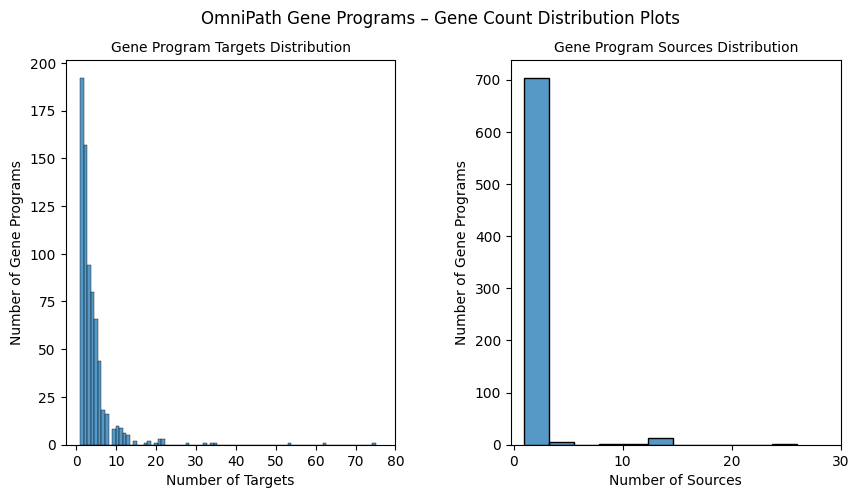

In [8]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True,
    gp_gene_count_distributions_save_path=f"{figure_folder_path}" \
                                           "/omnipath_gp_gene_count_distributions.svg")

In [9]:
omnipath_gp_names = list(omnipath_gp_dict.keys())
random.shuffle(omnipath_gp_names)
omnipath_gp_name = omnipath_gp_names[0]
print(f"{omnipath_gp_name}: {omnipath_gp_dict[omnipath_gp_name]}")

CGB5_ligand_receptor_GP: {'sources': ['Cgb5'], 'targets': ['Lhcgr'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}


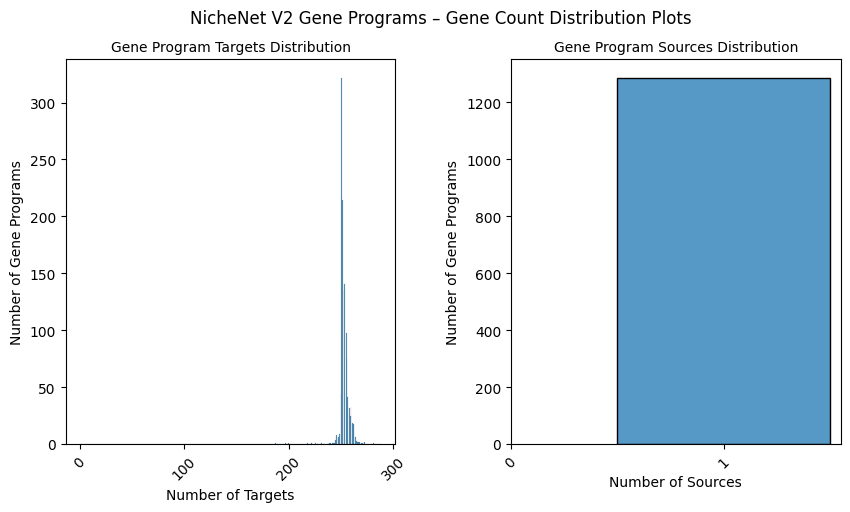

In [10]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=True,
    save_to_disk=True,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

In [11]:
nichenet_gp_names = list(nichenet_gp_dict.keys())
random.shuffle(nichenet_gp_names)
nichenet_gp_name = nichenet_gp_names[0]
#print(f"{nichenet_gp_name}: {nichenet_gp_dict[nichenet_gp_name]}")

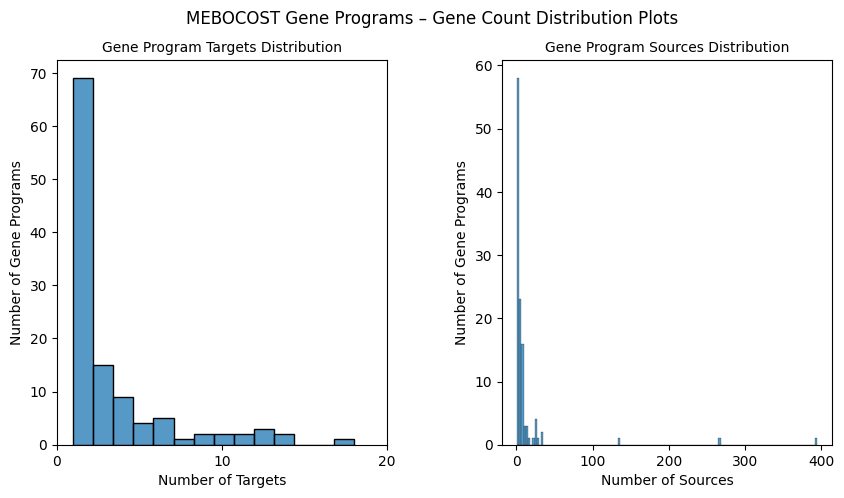

In [12]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_ms_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=True)

In [13]:
mebocost_gp_names = list(mebocost_gp_dict.keys())
random.shuffle(mebocost_gp_names)
mebocost_gp_name = mebocost_gp_names[0]
print(f"{mebocost_gp_name}: {mebocost_gp_dict[mebocost_gp_name]}")

Retinal_metabolite_enzyme_sensor_GP: {'sources': ['Adh1', 'Adh4', 'Adh5', 'Adh6b', 'Adh7', 'Dhrs3', 'Hsd17b6', 'Rdh10', 'Rdh11', 'Rdh8', 'Sdr16c5'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme'], 'targets': ['Rara', 'Rarb', 'Rarg', 'Rxra', 'Rxrb', 'Rxrg', 'Stra6'], 'targets_categories': ['sensor', 'sensor', 'sensor', 'sensor', 'sensor', 'sensor', 'sensor']}


In [14]:
adata_batch1 = sc.read_h5ad('/home/dbj/SpaLA/STARmap/starmap_plus_mouse_cns_batch1.h5ad')
adata_batch2 = sc.read_h5ad('/home/dbj/SpaLA/STARmap/starmap_plus_mouse_cns_batch2.h5ad')
adata_batch3 = sc.read_h5ad('/home/dbj/SpaLA/STARmap/starmap_plus_mouse_cns_batch3.h5ad')
adata_list=[adata_batch1,adata_batch2,adata_batch3]
adata = ad.concat(adata_list, join="inner")

In [15]:
data=pd.read_csv('/home/dbj/LPFoundation/STARmapPLUS/cluster.csv',index_col=0)
data=data.loc[adata.obs_names,:]
adata.obs['Main_molecular_tissue_region']=data['Main_molecular_tissue_region']

In [16]:
adata_batch_list = []
for batch in adata.obs['batch'].unique():
    adata_batch = adata[adata.obs['batch'] == batch].copy()
    sq.gr.spatial_neighbors(adata_batch,
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    
    # Make adjacency matrix symmetric
    adata_batch.obsp[adj_key] = (
        adata_batch.obsp[adj_key].maximum(
            adata_batch.obsp[adj_key].T))
    adata_batch_list.append(adata_batch)
adata = ad.concat(adata_batch_list, join="inner")

batch_connectivities = []
len_before_batch = 0
for i in range(len(adata_batch_list)):
    if i == 0: # first batch
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[0].shape[0],
            (adata.shape[0] -
            adata_batch_list[0].shape[0])))
        batch_connectivities.append(sp.hstack(
            (adata_batch_list[0].obsp[adj_key],
            after_batch_connectivities_extension)))
    elif i == (len(adata_batch_list) - 1): # last batch
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata.shape[0] -
            adata_batch_list[i].shape[0])))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key])))
    else: # middle batches
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0], len_before_batch))
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata.shape[0] -
            adata_batch_list[i].shape[0] -
            len_before_batch)))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key],
            after_batch_connectivities_extension)))
    len_before_batch += adata_batch_list[i].shape[0]
adata.obsp[adj_key] = sp.vstack(batch_connectivities)

In [17]:
%%time
gp_dicts = [omnipath_gp_dict, nichenet_gp_dict, mebocost_gp_dict]
combined_gp_dict = filter_and_combine_gp_dict_gps_v2(
    gp_dicts,
    verbose=False)

add_gps_from_gp_dict_to_adata(
    gp_dict=combined_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=2,
    min_source_genes_per_gp=1,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

from scipy.sparse import issparse, csr_matrix
if adata.X.dtype != np.float32:
    print(f"Converting adata.X from {adata.X.dtype} to float32...")
    adata.X = adata.X.astype(np.float32)
X = adata.X.copy()
if not issparse(X):
    X_csr = csr_matrix(X)
else:
    X_csr = X.tocsr()
adata.X = X_csr
adata.layers["counts"] = X_csr

model = NicheCompass(adata,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     cat_covariates_embeds_injection=cat_covariates_embeds_injection,
                     cat_covariates_keys=cat_covariates_keys,
                     cat_covariates_no_edges=cat_covariates_no_edges,
                     cat_covariates_embeds_nums=cat_covariates_embeds_nums,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                     latent_key=latent_key,
                     conv_layer_encoder=conv_layer_encoder,
                     active_gp_thresh_ratio=active_gp_thresh_ratio)

model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=100000,
            n_sampled_neighbors=n_sampled_neighbors,
            use_cuda_if_available=use_cuda_if_available,
            verbose=False)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
CATEGORICAL COVARIATES EMBEDDINGS INJECTION -> ['gene_expr_decoder']
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 1022, n_cat_covariates_embed_input: 0, n_hidden: 297, n_latent: 197, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 197, n_addon_gp_input: 100, n_cat_covariates_embed_input: 3, n_output: 1022
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 197, n_addon_gp_input: 100, n_cat_covariates_embed_input: 3, n_output: 1022

--- INITIALIZING TRAINER ---
Number of training nodes: 380406
Number of validation nodes: 42267
Number of training edges: 1

In [18]:
adata2=model.adata

In [19]:
%%time
sc.pp.neighbors(adata2, use_rep='nichecompass_latent')
sc.tl.umap(adata2)

CPU times: user 46min 3s, sys: 12min 4s, total: 58min 8s
Wall time: 4min 51s


In [20]:
adata2.write_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Fig4NicheSTARmapPLUS.h5ad',compression='gzip')

/home/dbj/anaconda3/envs/NicheCompass/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/dbj/anaconda3/envs/NicheCompass/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dbj/anaconda3/envs/NicheCompass/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dbj/anaconda3/envs/NicheCompass/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


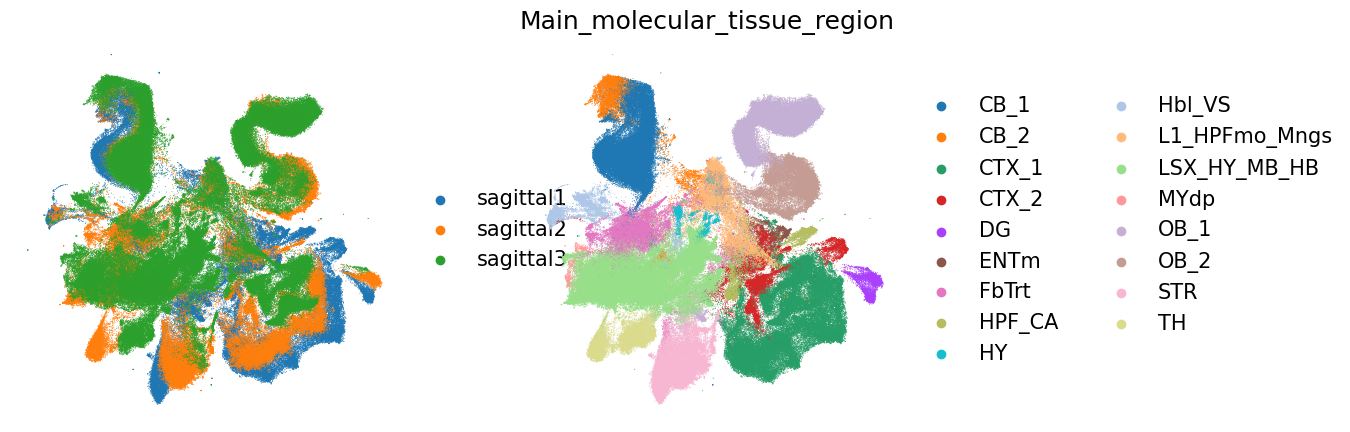

In [4]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 15
sc.pl.umap(adata=adata2,color=['batch','Main_molecular_tissue_region'],title='',size=1.5,colorbar_loc=None,frameon=False)